## Bayesian filters
*Bayesian filters* are often used in many signal processing applications. In this notebook, we will develop the topic by incrementally building intuition around how Bayesian statistics work.

### Tracking an object
Lets begin with a simple example. We are interested in writing a simple software that tracks where our Roomba is in the house (lets just ignore for a moment that such a feature is already provided by the Roomba itself :)). To begin, we attach a tracker that is able to notify us where the robot is along a long corridor. As the data streams in, we will read *door, empty, empty, door, empty, empty, ...*, where *empty* denotes a free space. Now, how can I use the information to determine where the robot is given this series of data?

For simplicity, we will model the corridor as an array of 10 discrete positions, indexed from 0 through 9. Initially, when we begin reading the sensor, we have no idea where the robot is. It is thus reasonable to assume the robot is equally like to be on any position, i.e., the probability in any position is 0.1. We can model our belief as:

In [6]:
import numpy as np
belief = 0.1*np.ones(10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


This is called a [*prior*](https://en.wikipedia.org/wiki/Prior_probability). It is the probability *prior* to incorporating any measurements. For Bayesian statistics [*prior*](https://en.wikipedia.org/wiki/Bayesian_probability), past events are considered when evaluation the occurence of a certain event. Take for example, weather forcasting where the occurence of rain in different seasons in the pasts are considered when predicting if it will rain tomorrow.

Now, lets model the map with numbers. Let *door* be 1 and *empty* be 0, i.e.

In [7]:
corridor = np.array([0,1,1,0,0,0,0,1,0,0])

Assuming the first data is *door*, we have reason to believe that the robot is at one of the doors, i.e.

In [8]:
import matplotlib.pyplot as plt
belief = 1/3*np.array([0,1,1,0,0,0,0,1,0,0])
pos = np.arange(len(belief))
plt.bar(pos,belief,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.show()

### Noisy sensor readings
Despite the amount of engineering going into creating sensors, it is unavoidable that they still come with some amount of noise. For the given example, the resulting probability looks like the following:

In [9]:
belief = np.array([0.3,0.3,0.1,0.1,0.1,0.1,0.1,0.1,0.3,0.1])

There is always noise in sensor readings, some may be due to the sensor mechanics. As such, the sum of beliefs is no longer 1. For simplicity, lets use a naive normalization method:

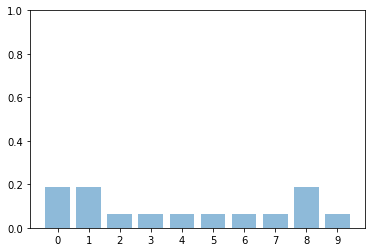

In [10]:
belief = belief / sum(belief)
pos = np.arange(len(belief))
plt.bar(pos,belief,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.show()

Suppose we want to normalize the probability distribution using a sensor model where the [*likelihood*](https://en.wikipedia.org/wiki/Likelihood_function) that a sensor is correctly identifying a state is 3 times more likely as compared to an incorrect detection. Hence, when we read a 1 for door, we need to scale it to: 
$\frac{likelihood \times prior}{normalization}$ 

sum =  1.0
p_door =  0.1875


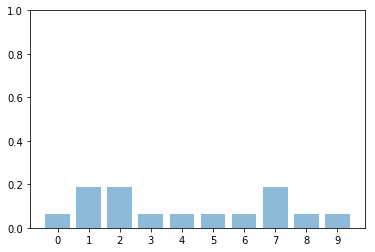

In [11]:
def update(corridor, belief, z, prob_correct):
    scale = prob_correct/(1-prob_correct)
    belief[corridor==z] *= scale
    # normalize
    n = 1/sum(belief)
    belief *= n

belief = np.array([0.1] * 10)
update(corridor, belief, z=1, prob_correct=0.75)

print('sum = ', sum(belief))
print('p_door = ', belief[1])

pos = np.arange(len(belief))
plt.bar(pos,belief,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.show()

This result is called the [*posterior*](https://en.wikipedia.org/wiki/Posterior_probability) or the *posterior probability distribution*. All this means is a probability after incorporating the measurement information. The state after incorporating the measurements is also called *estimation*

### Incorporating movement
Suppose that you are given also the past measurements, will you be able to better guess where the robot is? The answer is yes! As previously mentioned, the robot's sensor can be corrupted with noise, resulting in possible overshoot or undershoot. 

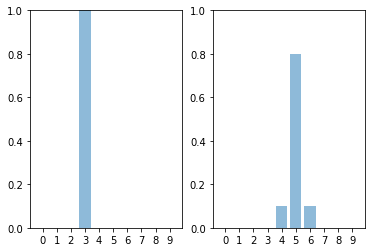

In [12]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
plt.subplot(121)
pos = np.arange(len(belief))
plt.bar(pos,belief,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.subplot(122)
pos = np.arange(len(prior))
plt.bar(pos,prior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.show()

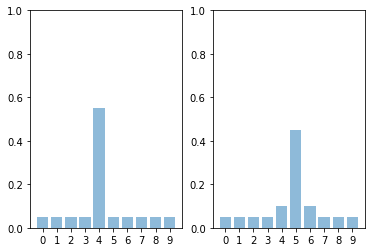

In [13]:
def predict_move_convolve(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1) / 2)

    prior = np.zeros(N)
    for i in range(N):
        for k in range (kN):
            index = (i + (width-k) - offset) % N
            prior[i] += pdf[index] * kernel[k]
    return prior

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05, .05]
prior = predict_move_convolve(belief, offset=1, kernel=[.1, .8, .1])
plt.subplot(121)
pos = np.arange(len(belief))
plt.bar(pos,belief,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.subplot(122)
pos = np.arange(len(prior))
plt.bar(pos,prior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,1])
plt.show()

Here, we shift the pdf by an offset to simulate a move and then convolve the resultant pdf with a kernel.

### Integrating measurements and movement updates
With the update and prediction steps described above, we can construct a tracker by feeding the results of one into the other. Let us assume that the robot is at poisition 0 and moving to along the corridor. We start by updating the prior with the likelihood information to get the posterior probability distribution.

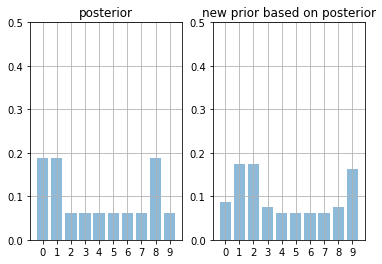

In [14]:
def compute_lh(corridor, z, z_prob):
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(corridor))
    likelihood[corridor==z] *= scale
    return likelihood

def update(likelihood, prior):
    scale = 1/sum(likelihood * prior)
    return scale*likelihood * prior

# setup
corridor = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

# update (prior -> posterior)
prior = np.array([.1] * 10)
likelihood = compute_lh(corridor, z=1, z_prob=.75)
posterior = update(likelihood, prior)
# predict (posterior -> prior)
prior = predict_move_convolve(posterior, 1, (.1, .8, .1))

plt.subplot(121)
plt.bar(np.arange(len(posterior)),posterior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,0.5])
plt.gca().set_title('posterior')
plt.grid()
plt.subplot(122)
plt.bar(np.arange(len(prior)),prior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,0.5])
plt.gca().set_title('new prior based on posterior')
plt.grid()
plt.show()

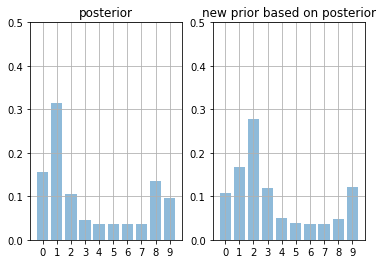

In [15]:
# update (prior -> posterior)
likelihood = compute_lh(corridor, z=1, z_prob=.75)
posterior = update(likelihood, prior)
# predict (posterior -> prior)
prior = predict_move_convolve(posterior, 1, (.1, .8, .1))

plt.subplot(121)
plt.bar(np.arange(len(posterior)),posterior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,0.5])
plt.gca().set_title('posterior')
plt.grid()
plt.subplot(122)
plt.bar(np.arange(len(prior)),prior,align='center',alpha=0.5)
plt.xticks(np.arange(min(pos), max(pos)+1, 1))
plt.gca().set_ylim([0,0.5])
plt.gca().set_title('new prior based on posterior')
plt.grid()
plt.show()

At this point, we have a predictor-corrector method to track an object where we go in an alternating fashion between (1) updating our estimates based on measurements and associated beliefs (2) predicting our state based on system behavior. Kalman filters use this exact algorithm; only the details of the computation is different.